<a href="https://colab.research.google.com/github/trevinofernando/AutoEncoder_ForMNIST/blob/main/AutoEncoder_ForMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

class AutoEencoder(nn.Module):
    def __init__(self, mode):
        super(AutoEencoder, self).__init__()
        
        # Define various layers here for forward to choose from and use later.
        
        self.maxPool1 = nn.MaxPool2d(2, 2, return_indices=True)
        self.maxUnpool1 = nn.MaxUnpool2d(2, 2)

        # Building a linear encoder-decoder with Linear
        # layer followed by Relu activation function
        # 784 ==> 128 ==> 784
        self.encoder_1_in = torch.nn.Linear(28 * 28, 256)
        self.encoder_1_out = torch.nn.Linear(256, 128)
        self.decoder_1_in = torch.nn.Linear(128, 256)
        self.decoder_1_out = torch.nn.Linear(256, 28 * 28)

        #=====================================================

        # Building a linear encoder-decoder with Linear
        # => 1x28x28 ==> 128 ==> 1x28x28
        self.encoder_2_conv1 = nn.Conv2d(1,10,3, stride=1, padding=1) #=> 10x28x28
        #pool => 10x14x14
        self.encoder_2_conv2 = nn.Conv2d(10,40,3, stride=1, padding=1)#=> 40x14x14
        #pool => 40x7x7
        self.encoder_2_in = nn.Linear(40 * 7 * 7, 256)
        self.encoder_2_out = torch.nn.Linear(256, 128)

        self.decoder_2_in = torch.nn.Linear(128, 256)
        self.decoder_2_out = torch.nn.Linear(256, 40 * 7 * 7) #=> 40x7x7
        #unpool => 40x14x14
        self.decoder_2_convTrans1 = nn.ConvTranspose2d(40, 10, 3, stride=1, padding=1, output_padding=0)#=> 10x14x14
        #unpool => 10x28x28
        self.decoder_2_convTrans2 = nn.ConvTranspose2d(10, 1, 3, stride=1, padding=1, output_padding=0)#=> 1x28x28

        # This will select the forward pass function based on mode for the AutoEencoder.
        # Based on the question, you have 5 modes available for step 1 to 5.
        # During creation of each AutoEencoder model, you will assign one of the valid mode.
        # This will fix the forward function (and the network graph) for the entire training/testing
        if mode == 1:
            self.forward = self.model_1
        elif mode == 2:
            self.forward = self.model_2
        else: 
            print("Invalid mode ", mode, "selected. Select between 1-5")
            exit(0)
        
        
    # Baseline model. step 1
    def model_1(self, x):
        # ======================================================================
        # Fully connected layers. 
        # ----------------------------------------------------------------------
        # Implement an autoencoder using fully connected layers. The encoder will 
        # have 2 layers (with 256, and 128 neurons) and the decoder will also have 
        # two layers (with 256 and 784 neurons). Train this network using MSEloss 
        # for 10 epochs. Compare the number of parameters in the encoder and the 
        # decoder. Show 20 sample reconstructed images from testing data in the
        # report (2 image for each class) along with the original images.
        # ======================================================================
        
        #Encoder:
        x = torch.flatten(x,1)
        x = self.encoder_1_in(x)
        x = F.relu(x)
        x = self.encoder_1_out(x)
        x = F.relu(x)
        
        #Decoder:
        x = self.decoder_1_in(x)
        x = F.relu(x)
        x = self.decoder_1_out(x)
        x = torch.sigmoid(x)

        return x

    # Use two convolutional layers.
    def model_2(self, x):
        # ======================================================================
        # Convolutional layers + fully connected layers.
        # ----------------------------------------------------------------------
        # The encoder will have two concolutional layers, and two max-pooling layers 
        # followed by each convolutional layers. Use kernel size 3x3, relu activation, 
        # and padding of 1 to preserve the shape of the input feature map. 
        # The decoder will have three convolutional layers with kernel shape 3x3 and 
        # padding of 1 to preserve the feature map shape. The ﬁrst two convolution layer 
        # will be followed by an upsampling layer, which will double the resolution of 
        # feature maps using linear interpolation.
        # ======================================================================
        #Encoder:
        x = self.encoder_2_conv1(x)
        x, indices1 = self.maxPool1(x)
        x = self.encoder_2_conv2(x)
        x, indices2 = self.maxPool1(x)
        x = torch.flatten(x,1)
        x = self.encoder_2_in(x)
        x = F.relu(x)
        x = self.encoder_2_out(x)
        x = F.relu(x)
        
        #Decoder:
        x = self.decoder_2_in(x)
        x = F.relu(x)
        x = self.decoder_2_out(x)
        x = F.relu(x)
        x = self.maxUnpool1(x.view_as(indices2), indices2)
        x = self.decoder_2_convTrans1(x)
        x = F.relu(x)
        x = self.maxUnpool1(x.view_as(indices1), indices1)
        x = self.decoder_2_convTrans2(x)
        x = torch.sigmoid(x)
        return x

In [5]:
from __future__ import print_function
import argparse
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
#from AutoEencoder import AutoEencoder 
import argparse
import numpy as np 
import matplotlib.pyplot as plt

def train(model, device, train_loader, optimizer, criterion, epoch, batch_size):
    '''
    Trains the model for an epoch and optimizes it.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    train_loader: dataloader for training samples.
    optimizer: optimizer to use for model parameter updates.
    criterion: used to compute loss for prediction and target 
    epoch: Current epoch to train for.
    batch_size: Batch size to be used.
    '''
    
    # Set model to train mode before each epoch
    model.train()
    
    # Empty list to store losses 
    losses = []
    correct = 0
    
    # Iterate over entire training samples (1 epoch)
    for batch_idx, batch_sample in enumerate(train_loader):
        data, target = batch_sample
        
        # Push data/label to correct device
        data, target = data.to(device), data.to(device) #target.to(device)
        
        # Reset optimizer gradients. Avoids grad accumulation (accumulation used in RNN).
        optimizer.zero_grad()
        
        # Do forward pass for current set of data
        output = model(data)
        
        # ======================================================================
        # Compute loss based on criterion
        loss = criterion(output.view_as(target), target)
        
        # Computes gradient based on final loss
        loss.backward()
        
        # Store loss
        losses.append(loss.item())
        
        # Optimize model parameters based on learning rate and gradient 
        optimizer.step()
        
        # Get prediction
        pred = output.view_as(target)

        # ======================================================================
        # Count correct predictions overall 
        #correct += pred.eq(target.view_as(pred)).sum().item() 
        correct += 1 - (torch.sum((torch.absolute(target-pred))) / (target.numel() * torch.max(target.max(), pred.max())))
        
    train_loss = float(np.mean(losses))
    train_acc = correct / ((batch_idx+1) * batch_size)
    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        float(np.mean(losses)), correct, (batch_idx+1) * batch_size,
        100. * correct / ((batch_idx+1) * batch_size)))
    return train_loss, train_acc
    


def test(model, device, test_loader, criterion):
    '''
    Tests the model.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    test_loader: dataloader for test samples.
    '''
    
    # Set model to eval mode to notify all layers.
    model.eval()
    
    losses = []
    correct = 0
    
    # Set torch.no_grad() to disable gradient computation and backpropagation
    with torch.no_grad():
        for batch_idx, sample in enumerate(test_loader):
            data, target = sample
            data, target = data.to(device), data.to(device) #target.to(device)
            

            # Predict for data by doing forward pass
            output = model(data)
            
            # ======================================================================
            # Compute loss based on same criterion as training
            loss = criterion(output.view_as(target), target)
            
            # Append loss to overall test loss
            losses.append(loss.item())
            
            # Get prediction
            pred = output.view_as(target)
            
            # ======================================================================
            # Count correct predictions overall 
            #correct += pred.eq(target.view_as(pred)).sum().item() 
            correct += 1 - (torch.sum((torch.absolute(target-pred))) / (target.numel() * torch.max(target.max(), pred.max())))

    test_loss = float(np.mean(losses))
    accuracy = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))
    
    return test_loss, accuracy
    

def run_main(FLAGS):
    # Check if cuda is available
    use_cuda = torch.cuda.is_available()
    
    # Set proper device based on cuda availability 
    device = torch.device("cuda" if use_cuda else "cpu")
    print("Torch device selected: ", device)
    
    # Initialize the model and send to device 
    print("Using model #", FLAGS.mode)
    model = AutoEencoder(FLAGS.mode).to(device)
    
    # ======================================================================
    # Define loss function.
    criterion = nn.MSELoss()
    
    # ======================================================================
    # Define optimizer function with learning rate and other paramters.
    optimizer = optim.SGD(model.parameters(), lr=FLAGS.learning_rate)
        
    
    # Create transformations to apply to each data sample 
    # Can specify variations such as image flip, color flip, random crop, ...
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    
    # Load datasets for training and testing
    # Inbuilt datasets available in torchvision (check documentation online)
    dataset1 = datasets.MNIST('./data/', train=True, download=True, transform=transform)
    dataset2 = datasets.MNIST('./data/', train=False, transform=transform)
    train_loader = DataLoader(dataset1, batch_size = FLAGS.batch_size, shuffle=True, num_workers=4)
    test_loader =  DataLoader(dataset2, batch_size = FLAGS.batch_size, shuffle=False, num_workers=4)
    
    best_accuracy = 0.0
    train_loss_list = []
    test_loss_list = []
    train_accuracy_list = []
    test_accuracy_list = []
    
    # Run training for n_epochs specified in config 
    for epoch in range(1, FLAGS.num_epochs + 1):
        print("Current epoch: ", epoch)
        train_loss, train_accuracy = train(model, device, train_loader, optimizer, criterion, epoch, FLAGS.batch_size)
        test_loss, test_accuracy = test(model, device, test_loader, criterion)
        
        train_loss_list.    append(train_loss)
        test_loss_list.     append(test_loss)
        train_accuracy_list.append(train_accuracy)
        test_accuracy_list. append(test_accuracy)

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
    
    epoch_list = range(0,epoch)
    plt.plot(epoch_list, train_loss_list)
    plt.xlabel("No. of epochs")
    plt.ylabel("Loss")
    plt.title("Epochs vs Train Loss")
    plt.show()

    plt.plot(epoch_list, test_loss_list)
    plt.xlabel("No. of epochs")
    plt.ylabel("Loss")
    plt.title("Epochs vs Test Loss")
    plt.show()

    plt.plot(epoch_list, train_accuracy_list)
    plt.xlabel("No. of epochs")
    plt.ylabel("Accuracy")
    plt.title("Epochs vs Train Accuracy")
    plt.show()

    plt.plot(epoch_list, test_accuracy_list)
    plt.xlabel("No. of epochs")
    plt.ylabel("Accuracy")
    plt.title("Epochs vs Test Accuracy")
    plt.show()
    
    print("accuracy is {:2.2f}".format(best_accuracy))
    
    print("Training and evaluation finished")
    
    if(FLAGS.log_dir):
      torch.save(model.state_dict(), FLAGS.log_dir)
    
if __name__ == '__main__':
    # Set parameters for Sparse Autoencoder
    parser = argparse.ArgumentParser('CNN Exercise.')
    parser.add_argument('--mode',
                        type=int, 
                        default=2,
                        help='Select mode between 1-5.')
    parser.add_argument('--learning_rate',
                        type=float, 
                        default=0.1,
                        help='Initial learning rate.')
    parser.add_argument('--num_epochs',
                        type=int,
                        default=60,
                        help='Number of epochs to run trainer.')
    parser.add_argument('--batch_size',
                        type=int, 
                        default=10,
                        help='Batch size. Must divide evenly into the dataset sizes.')
    parser.add_argument('--log_dir',
                        type=str,
                        default='logs',
                        help='Directory to put logging.')
    
    FLAGS = None
    FLAGS, unparsed = parser.parse_known_args()
    
    #run_main(FLAGS)
    

In [3]:
def VizualizeResults(FLAGS):
    model = AutoEencoder(FLAGS.mode)
    model.load_state_dict(torch.load(FLAGS.log_dir))
    model.eval()

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

    testDataset = datasets.MNIST('./data/', train=False, transform=transform)
    test_loader =  DataLoader(testDataset, batch_size = FLAGS.batch_size, shuffle=False, num_workers=4)

    sample = next(iter(test_loader))
    imgs, lbls = sample

    output = model(imgs)

    for i in range(10):
      output = output.reshape(-1, 28, 28)
      print("Input image")
      plt.imshow(imgs[i][0])
      plt.show()
      print("Reconstructed image")
      plt.imshow(output.detach().numpy()[i])
      plt.show()
      print("========================================")

Torch device selected:  cuda
Using model # 1
Current epoch:  1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train set: Average loss: 0.7417, Accuracy: 4528.4150390625/60000 (8%)


Test set: Average loss: 0.6474, Accuracy: 772.3148193359375/10000 (8%)

Current epoch:  2
Train set: Average loss: 0.6292, Accuracy: 4654.94482421875/60000 (8%)


Test set: Average loss: 0.6177, Accuracy: 777.9620361328125/10000 (8%)

Current epoch:  3
Train set: Average loss: 0.6063, Accuracy: 4677.796875/60000 (8%)


Test set: Average loss: 0.5997, Accuracy: 780.7301635742188/10000 (8%)

Current epoch:  4
Train set: Average loss: 0.5873, Accuracy: 4696.1953125/60000 (8%)


Test set: Average loss: 0.5815, Accuracy: 783.7145385742188/10000 (8%)

Current epoch:  5
Train set: Average loss: 0.5722, Accuracy: 4711.900390625/60000 (8%)


Test set: Average loss: 0.5694, Accuracy: 785.9205932617188/10000 (8%)

Current epoch:  6
Train set: Average loss: 0.5610, Accuracy: 4723.80322265625/60000 (8%)


Test set: Average loss: 0.5598, Accuracy: 787.7407836914062/10000 (8%)

Current epoch:  7
Train set: Average loss: 0.5530, A

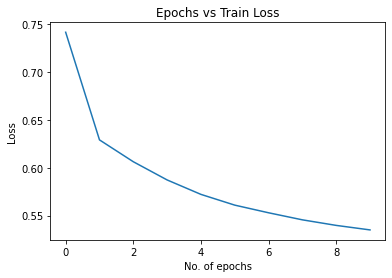

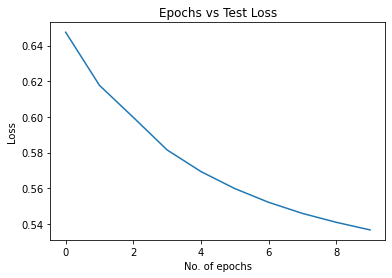

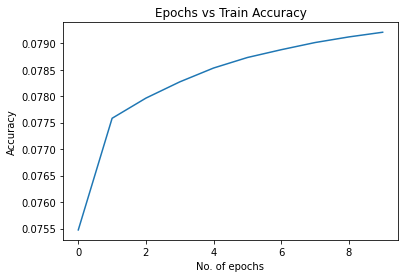

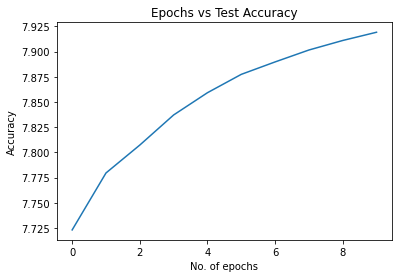

accuracy is 7.92
Training and evaluation finished
Input image


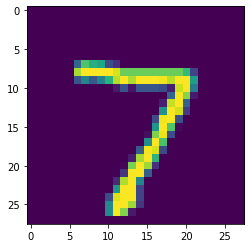

Reconstructed image


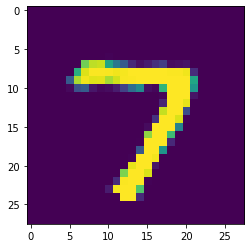

Input image


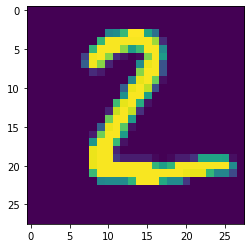

Reconstructed image


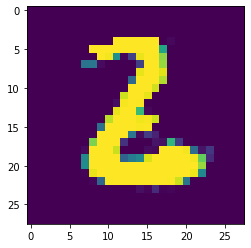

Input image


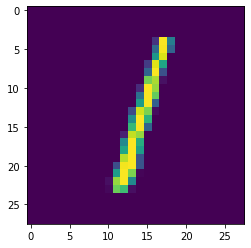

Reconstructed image


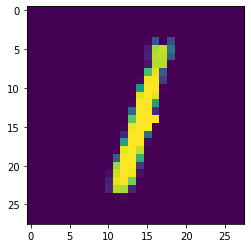

Input image


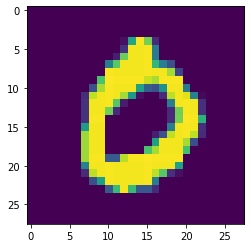

Reconstructed image


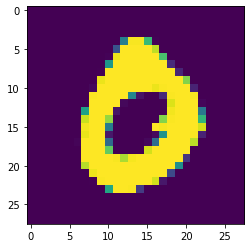

Input image


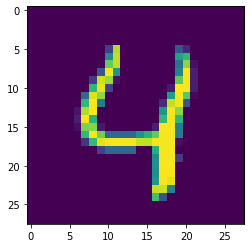

Reconstructed image


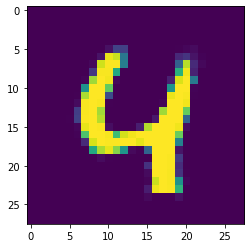

Input image


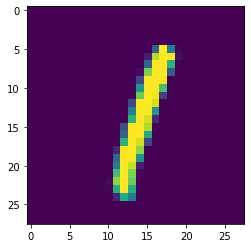

Reconstructed image


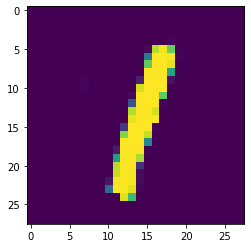

Input image


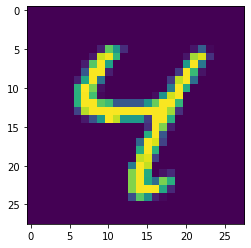

Reconstructed image


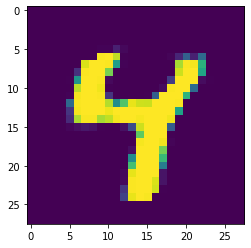

Input image


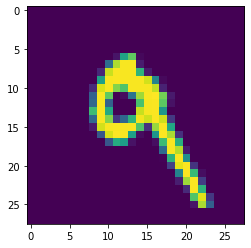

Reconstructed image


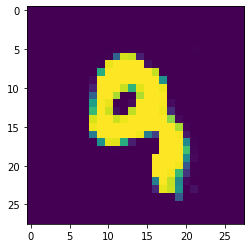

Input image


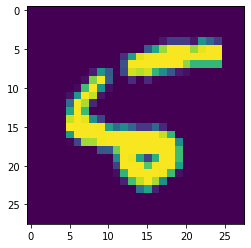

Reconstructed image


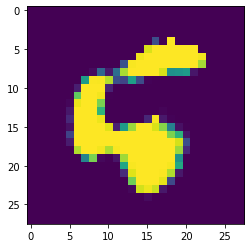

Input image


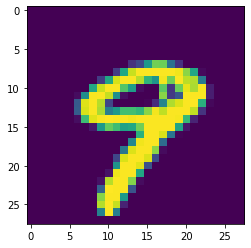

Reconstructed image


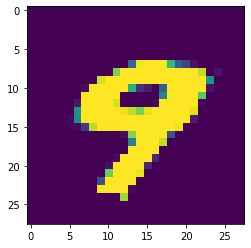

In [6]:
from argparse import Namespace
FLAGS = Namespace(batch_size=10, learning_rate=0.1, log_dir='AutoEncoder_1', mode=1, num_epochs=10)
run_main(FLAGS)
VizualizeResults(FLAGS)

Torch device selected:  cuda
Using model # 2
Current epoch:  1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:693: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch._C._nn.max_pool2d_with_indices(input, kernel_size, stride, padding, dilation, ceil_mode)


Train set: Average loss: 0.6272, Accuracy: 4684.12109375/60000 (8%)


Test set: Average loss: 0.4914, Accuracy: 798.8282470703125/10000 (8%)

Current epoch:  2
Train set: Average loss: 0.4827, Accuracy: 4801.64453125/60000 (8%)


Test set: Average loss: 0.4870, Accuracy: 799.7459106445312/10000 (8%)

Current epoch:  3
Train set: Average loss: 0.4795, Accuracy: 4806.0146484375/60000 (8%)


Test set: Average loss: 0.4847, Accuracy: 800.2825927734375/10000 (8%)

Current epoch:  4
Train set: Average loss: 0.4778, Accuracy: 4808.3037109375/60000 (8%)


Test set: Average loss: 0.4836, Accuracy: 800.5233764648438/10000 (8%)

Current epoch:  5
Train set: Average loss: 0.4769, Accuracy: 4809.73291015625/60000 (8%)


Test set: Average loss: 0.4825, Accuracy: 800.7877807617188/10000 (8%)

Current epoch:  6
Train set: Average loss: 0.4752, Accuracy: 4812.3134765625/60000 (8%)


Test set: Average loss: 0.4807, Accuracy: 801.2473754882812/10000 (8%)

Current epoch:  7
Train set: Average loss: 0.4742

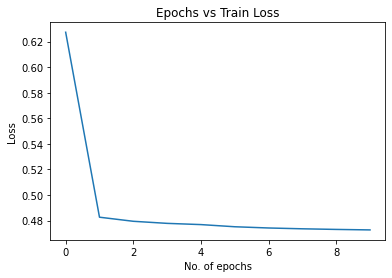

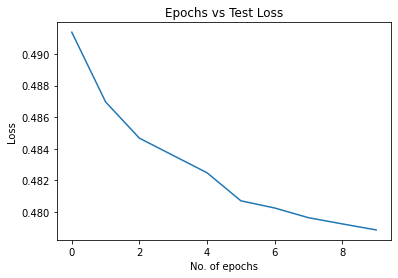

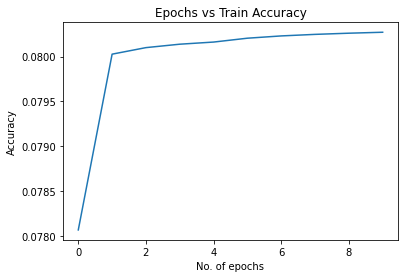

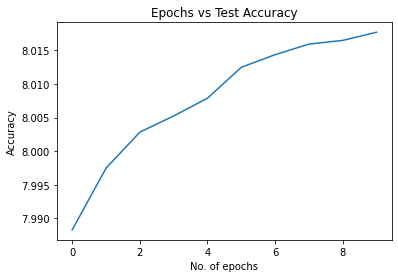

accuracy is 8.02
Training and evaluation finished
Input image


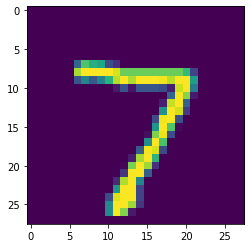

Reconstructed image


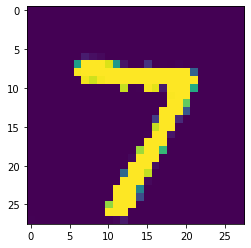

Input image


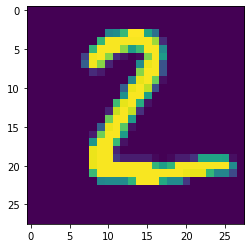

Reconstructed image


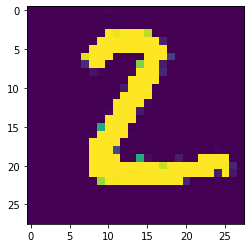

Input image


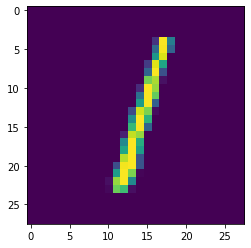

Reconstructed image


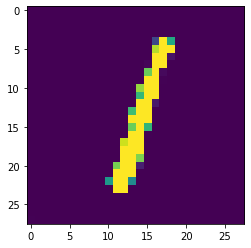

Input image


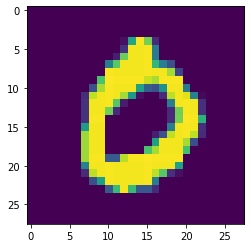

Reconstructed image


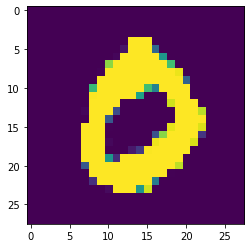

Input image


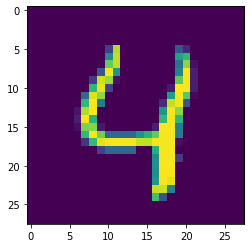

Reconstructed image


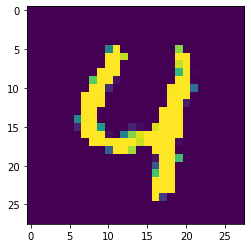

Input image


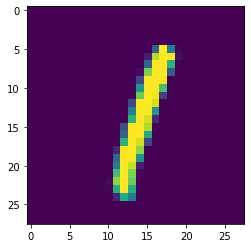

Reconstructed image


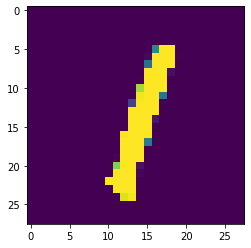

Input image


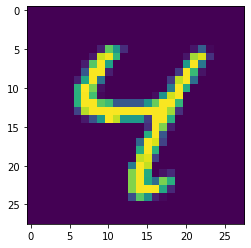

Reconstructed image


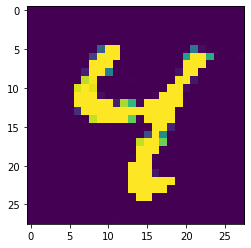

Input image


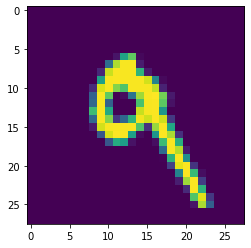

Reconstructed image


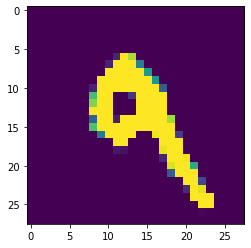

Input image


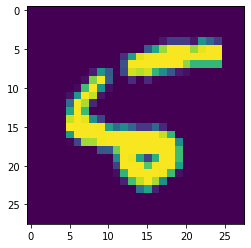

Reconstructed image


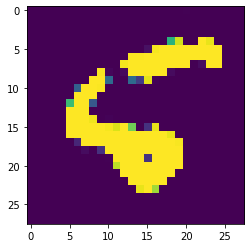

Input image


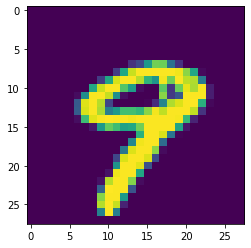

Reconstructed image


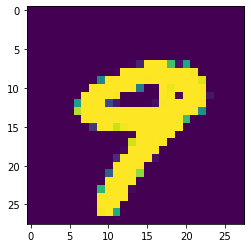

In [7]:
FLAGS = Namespace(batch_size=10, learning_rate=0.1, log_dir='AutoEncoder_2', mode=2, num_epochs=10)
run_main(FLAGS)
VizualizeResults(FLAGS)